# Brain Imaging Analysis and Reporting System

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetB0, MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from PIL import Image
from fpdf import FPDF
from ultralytics import YOLO

In [2]:
def load_and_preprocess_images(directory, target_size=(512, 512)):
    X, y = [], []
    class_folders = os.listdir(directory)
    class_folders.sort()

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Error: Unable to load {image_path}")
                        continue
                    image = cv2.resize(image, target_size)
                    if image.shape[-1] != 3:  # Handle grayscale images
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                    X.append(image)
                    y.append(class_index)
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")

    X = np.array(X) / 255.0  # Normalize images
    y = np.array(y)
    return X, y


In [3]:
# Load and preprocess images
path = "Brain Tumorabeled dataset"
X, y = load_and_preprocess_images(path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create and train a model (VGG16, EfficientNet, MobileNet)
def train_model(base_model, X_train, y_train, X_test, y_test, num_classes):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    return model


In [4]:
# Train VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
vgg16_model_final = train_model(vgg16_model, X_train, y_train, X_test, y_test, len(os.listdir(path)))


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 135s 15s/step - accuracy: 0.3755 - loss: 10.6158 - val_accuracy: 0.8657 - val_loss: 0.8748
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 127s 14s/step - accuracy: 0.6829 - loss: 2.6736 - val_accuracy: 0.8806 - val_loss: 0.4801
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.8276 - loss: 0.5120 - val_accuracy: 0.9403 - val_loss: 0.1909
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 127s 14s/step - accuracy: 0.9129 - loss: 0.2727 - val_accuracy: 0.9254 - val_loss: 0.1946
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.9198 - loss: 0.1834 - val_accuracy: 0.9701 - val_loss: 0.1418
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.9582 - loss: 0.0989 - val_accuracy: 0.9552 - val_loss: 0.1163
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.9545 - loss: 0.1231 - val_accuracy: 0.9701 - val_loss: 0.0891
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 14s/step - accuracy: 0.9678 - loss: 0.0789 - val_accuracy: 0.9403 - val_loss

In [5]:
# Evaluate the CNN models
vgg16_model_final.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.9886 - loss: 0.0559


[0.07149983197450638, 0.9850746393203735]

In [6]:
# Function to handle user image input
def handle_user_image_input(image_path, model):
    try:
        image = Image.open(image_path)
        result = predict_tumor(image, model)
        print(f"Prediction: {result}")

        if result == "Tumor Detected":
            image_with_box, tumor_detected = detect_and_draw_bounding_box(image_path)
            return result, image_with_box if tumor_detected else None
        else:
            return result, None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

In [7]:
# Function to generate a PDF report
def generate_pdf_report(image_path, prediction, image_with_box=None):
    pdf = FPDF()
    pdf.add_page()

    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Brain Tumor Detection Report", ln=True, align="C")

    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=f"Prediction: {prediction}", ln=True, align="L")

    if prediction == "Tumor Detected" and image_with_box is not None:
        output_image_path = "output_image_with_box.jpg"
        cv2.imwrite(output_image_path, image_with_box)
        pdf.image(output_image_path, x=10, y=30, w=100)
    else:
        pdf.image(image_path, x=10, y=30, w=100)

    output_path = "tumor_detection_report.pdf"
    pdf.output(output_path)
    print(f"PDF report generated: {output_path}")



In [7]:
# Example usage
image_path = "Tr-me_0552.jpg"  # Replace with actual image path
prediction, image_with_box = handle_user_image_input(image_path, vgg16_model_final)
if prediction:
    generate_pdf_report(image_path, prediction, image_with_box)



Error processing image: name 'predict_tumor' is not defined


3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step


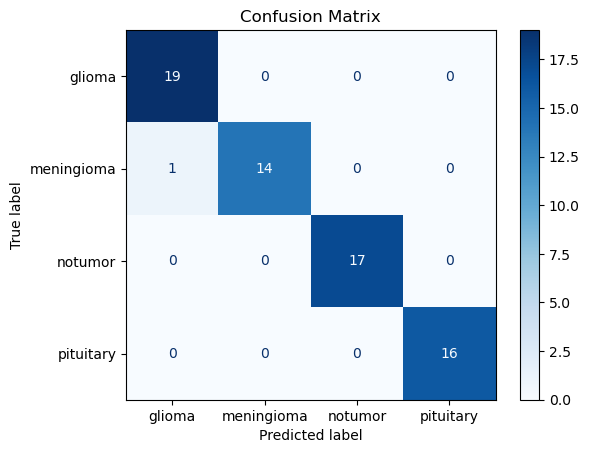

              precision    recall  f1-score   support

      glioma       0.95      1.00      0.97        19
  meningioma       1.00      0.93      0.97        15
     notumor       1.00      1.00      1.00        17
   pituitary       1.00      1.00      1.00        16

    accuracy                           0.99        67
   macro avg       0.99      0.98      0.98        67
weighted avg       0.99      0.99      0.99        67



In [20]:
# Generate confusion matrix and classification report
y_pred = vgg16_model_final.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use class names instead of numbers in confusion matrix and classification report
class_names = os.listdir(path)  # Get class names from directory
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix with class names
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Generate classification report using class names
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)

In [21]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.99
Recall: 0.99
F1 Score: 0.99


In [22]:
# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")




Precision: 0.99
Recall: 0.99
F1 Score: 0.99


In [23]:
# Calculate and display overall accuracy and loss for training and validation
train_loss, train_accuracy = vgg16_model_final.evaluate(X_train, y_train)
val_loss, val_accuracy = vgg16_model_final.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 112s 11s/step - accuracy: 1.0000 - loss: 0.0035
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.9886 - loss: 0.0559
Training Loss: 0.0019
Training Accuracy: 100.00%
Validation Loss: 0.0715
Validation Accuracy: 98.51%


In [8]:
# Save the trained model
model_save_path = "vgg16_brain_tumor_model.h5"
vgg16_model_final.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vgg16_brain_tumor_model.h5


## pipeline code

In [24]:
# Load the trained CNN model
cnn_model_path = "vgg16_brain_tumor_model.h5"  # Path to your saved CNN model
cnn_model = load_model(cnn_model_path)

# Load the YOLO model
yolo_model_path = r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect\train2\weights\best.pt'
yolo_model = YOLO(yolo_model_path)

# Class names for CNN classification
cnn_class_names = ["No Tumor", "Tumor"]  # Update as per your training setup

def preprocess_image(image_path, target_size=(512, 512)):
    """Preprocess the image for CNN prediction."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image
# Function to divide image into quadrants and determine tumor location
def determine_quadrant(image_shape, bbox):
    height, width = image_shape[:2]
    x_min, y_min, x_max, y_max = bbox

    # Calculate center of bounding box
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2

    # Determine quadrant
    if center_x < width / 2 and center_y < height / 2:
        return "Top-Left Quadrant"
    elif center_x >= width / 2 and center_y < height / 2:
        return "Top-Right Quadrant"
    elif center_x < width / 2 and center_y >= height / 2:
        return "Bottom-Left Quadrant"
    else:
        return "Bottom-Right Quadrant"
def predict_tumor_cnn(image_path):
    """Use CNN to classify the image."""
    image = preprocess_image(image_path)
    predictions = cnn_model.predict(image)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    return cnn_class_names[predicted_class], confidence

# Updated function for YOLO detection with quadrant calculation
def detect_and_draw_bounding_box(image_path):
    """Use YOLO to detect tumors, draw bounding boxes, and determine the tumor's quadrant."""
    results = yolo_model.predict(image_path)
    if len(results[0].boxes) > 0:  # Check if detections exist
        detected_image = results[0].plot()  # Plot boxes on the image
        bbox = results[0].boxes[0].xyxy[0].tolist()  # Get the first detection's bbox
        quadrant = determine_quadrant(cv2.imread(image_path).shape, bbox)
        return detected_image, bbox, quadrant
    return None, None, None

# Generate PDF Report with quadrant and bounding box
def generate_pdf_report(image_path, prediction, confidence, image_with_box=None, bbox=None, quadrant=None):
    """Generate a PDF report."""
    pdf = FPDF()
    pdf.add_page()

    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Brain Tumor Detection Report", ln=True, align="C")

    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=f"Prediction: {prediction} (Confidence: {confidence:.2f})", ln=True, align="L")

    if prediction == "Tumor":
        if bbox and quadrant:
            pdf.cell(200, 10, txt=f"Bounding Box: {bbox}", ln=True, align="L")
            pdf.cell(200, 10, txt=f"Quadrant: {quadrant}", ln=True, align="L")

        if image_with_box is not None:
            output_image_path = "output_image_with_box.jpg"
            cv2.imwrite(output_image_path, image_with_box)
            pdf.image(output_image_path, x=10, y=50, w=100)
    else:
        pdf.image(image_path, x=10, y=50, w=100)

    output_path = "tumor_detection_report.pdf"
    pdf.output(output_path)
    print(f"PDF report generated: {output_path}")

# Main pipeline function with quadrant detection
def process_image(image_path):
    """Process an input image through the pipeline, including quadrant detection."""
    prediction, confidence = predict_tumor_cnn(image_path)
    print(f"Classification Result: {prediction} with confidence {confidence:.2f}")

    if prediction == "Tumor":
        image_with_box, bbox, quadrant = detect_and_draw_bounding_box(image_path)
        if bbox:
            print(f"Tumor detected in {quadrant}. Bounding box: {bbox}")
        generate_pdf_report(image_path, prediction, confidence, image_with_box, bbox, quadrant)
    else:
        print("No tumor detected. Skipping YOLO.")
        generate_pdf_report(image_path, prediction, confidence)

# Example usage
input_image_path = "Tr-gl_0483.jpg"  # Replace with your test image path
process_image(input_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Result: No Tumor with confidence 1.00
No tumor detected. Skipping YOLO.
PDF report generated: tumor_detection_report.pdf


In [25]:
# Example usage
input_image_path = "Tr-me_0515.jpg"  # Replace with your test image path
process_image(input_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Result: Tumor with confidence 1.00

image 1/1 C:\Users\PC\Downloads\fyp\Brain-Imaging-Analysis-and-Reporting-System-main\Tr-me_0515.jpg: 640x640 1 meningioma, 753.3ms
Speed: 256.5ms preprocess, 753.3ms inference, 195.2ms postprocess per image at shape (1, 3, 640, 640)
Tumor detected in Top-Right Quadrant. Bounding box: [255.3573455810547, 129.51025390625, 357.7661437988281, 228.65188598632812]
PDF report generated: tumor_detection_report.pdf


## not included

In [14]:
# Generate PDF Report with quadrant and bounding box
def generate_pdf_report(image_path, prediction, confidence, image_with_box=None, bbox=None, quadrant=None):
    """Generate a PDF report."""
    pdf = FPDF()
    pdf.add_page()

    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Brain Tumor Detection Report", ln=True, align="C")

    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=f"Prediction: {prediction} (Confidence: {confidence:.2f})", ln=True, align="L")

    if prediction == "Tumor":
        if bbox and quadrant:
            pdf.cell(200, 10, txt=f"Bounding Box: {bbox}", ln=True, align="L")
            pdf.cell(200, 10, txt=f"Quadrant: {quadrant}", ln=True, align="L")

        if image_with_box is not None:
            output_image_path = "output_image_with_box.jpg"
            cv2.imwrite(output_image_path, image_with_box)
            pdf.image(output_image_path, x=10, y=50, w=100)
    else:
        pdf.image(image_path, x=10, y=50, w=100)

    output_path = "tumor_detection_report.pdf"
    pdf.output(output_path)
    print(f"PDF report generated: {output_path}")

# Updated function for YOLO detection with quadrant calculation
def detect_and_draw_bounding_box(image_path):
    """Use YOLO to detect tumors, draw bounding boxes, and determine the tumor's quadrant."""
    results = yolo_model.predict(image_path)
    if len(results[0].boxes) > 0:  # Check if detections exist
        detected_image = results[0].plot()  # Plot boxes on the image
        bbox = results[0].boxes[0].xyxy[0].tolist()  # Get the first detection's bbox
        quadrant = determine_quadrant(cv2.imread(image_path).shape, bbox)
        return detected_image, bbox, quadrant
    return None, None, None

# Main pipeline function with quadrant detection
def process_image(image_path):
    """Process an input image through the pipeline, including quadrant detection."""
    prediction, confidence = predict_tumor_cnn(image_path)
    print(f"Classification Result: {prediction} with confidence {confidence:.2f}")

    if prediction == "Tumor":
        image_with_box, bbox, quadrant = detect_and_draw_bounding_box(image_path)
        if bbox:
            print(f"Tumor detected in {quadrant}. Bounding box: {bbox}")
        generate_pdf_report(image_path, prediction, confidence, image_with_box, bbox, quadrant)
    else:
        print("No tumor detected. Skipping YOLO.")
        generate_pdf_report(image_path, prediction, confidence)

# Example usage
input_image_path = "Tr-me_0556.jpg"  # Replace with your test image path
process_image(input_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Result: Tumor with confidence 1.00

image 1/1 C:\Users\PC\Downloads\fyp\Brain-Imaging-Analysis-and-Reporting-System-main\Tr-me_0556.jpg: 640x640 1 meningioma, 70.5ms
Speed: 2.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Tumor detected in Top-Left Quadrant. Bounding box: [160.5937957763672, 88.47514343261719, 249.7942352294922, 163.73892211914062]
PDF report generated: tumor_detection_report.pdf
